
In this section, we will load a dataset, do exploratory data analysis (EDA) such as visualizing the distributions. We do typical preprocessing tasks such as encode categorical variables and normalize, and rescale for neural network training. We will then create a simple neural network model in keras and train the model plotting in offline fashion and using a generator, and plot the training and validation performance.


In this recipe, we are going to look at a still quite simple dataset, the [adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult) from the [UCI machine learning repository](http://archive.ics.uci.edu/ml/datasets). With this dataset (also known as Census Income dataset), the goal is to predict from census data, whether someone earns more than 50,000 dollars.

This dataset is already split into training and test. We will start by loading training and test sets.

In [0]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2019-12-10 20:33:09--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  3.59MB/s    in 1.1s    

2019-12-10 20:33:11 (3.59 MB/s) - ‘adult.data’ saved [3974305/3974305]



In [0]:
import pandas as pd
train = pd.read_csv(
    'adult.data',
    names=['age', 'workclass', 'fnlwgt',
             'education', 'education-num',
             'marital-status', 'occupation',
             'relationship', 'race', 'sex',
             'capital-gain', 'capital-loss',
             'hours-per-week', 'native-country', '50k']
             )
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
50k               32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We have the following information from the UCI description page: 
* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, etc.

"fnlwgt" actually stands for the final weight, i.e. the total number of people constituting the entry.

In [0]:
train.select_dtypes(include='object').columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', '50k'],
      dtype='object')

We cannot do much with string encoding, unfortunately. As a first step we are going to transform these variables using Ordinal Encoding. We can do this very flexibly using the *category_encoding* package in *sklearn-contrib*.


In [0]:
pip install category_encoders

     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
import category_encoders as ce

X = train.drop('50k', axis=1)
encoder = ce.OrdinalEncoder(cols=list(X.select_dtypes(include='object').columns)[:])
encoder.fit(X, train['50k'])
X_cleaned = encoder.transform(X)

X_cleaned.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,1,77516,1,13,1,1,1,1,1,2174,0,40,1
1,50,2,83311,1,13,2,2,2,1,1,0,0,13,1
2,38,3,215646,2,9,3,3,1,1,1,0,0,40,1
3,53,3,234721,3,7,2,3,2,2,1,0,0,40,1
4,28,3,338409,1,13,2,4,3,2,2,0,0,40,2


When starting with a new task, the best is often to examine the data. Let us have a look at the variables.

In [0]:
from scipy import stats
from matplotlib import pyplot
a5_dims = (8.27, 11.7 / 2)
import seaborn as sns
sns.set(color_codes=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

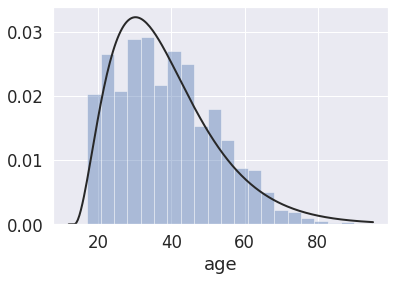

In [0]:
sns.distplot(train['age'], bins=20, kde=False, fit=stats.gamma);

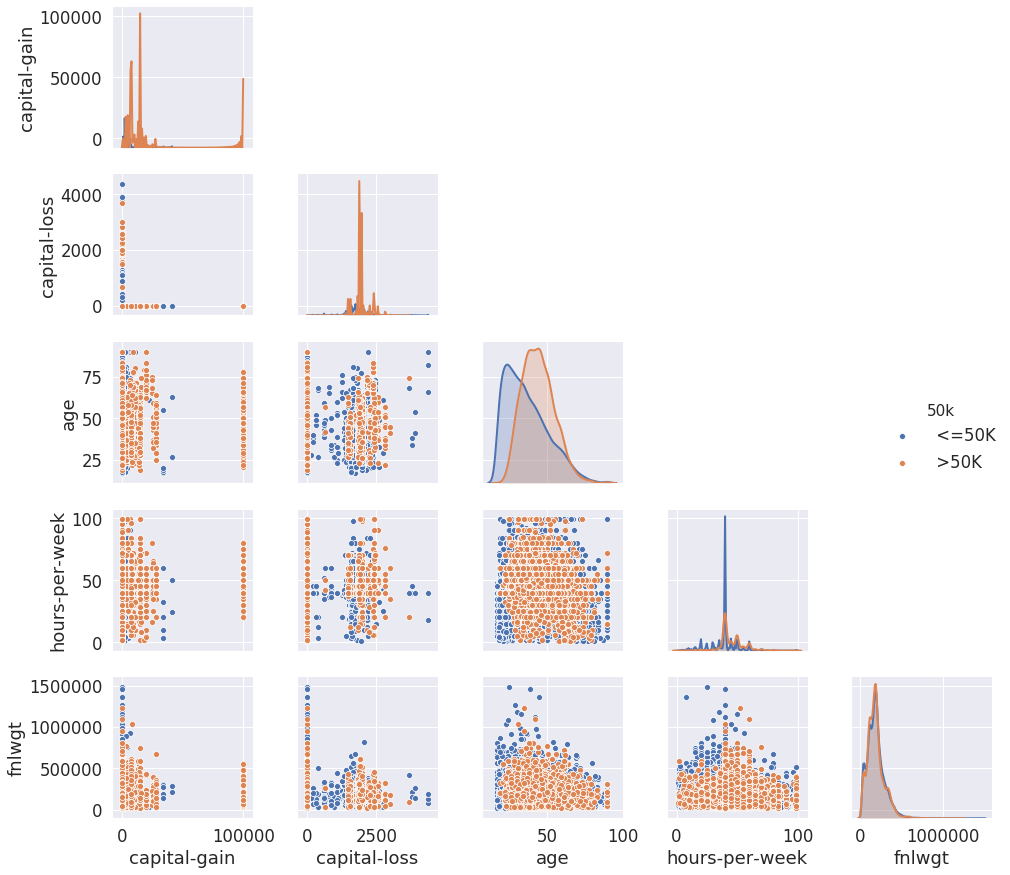

In [0]:
# plot all numeric variables against each other
g = sns.pairplot(
    train[list(
        set(train.select_dtypes(include='number').columns)
        - set(['education-num'])
        ) + ['50k']],
    hue='50k',
    height=2.5,
    aspect=1,
)
import numpy as np
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

We can observe variables with respect to each other. For example, we can ask if age could be one of the determiners of higher salary.

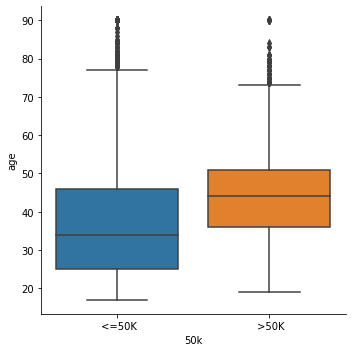

In [0]:
sns.catplot(x='50k', y='age', kind='box', data=train)


To get an idea of the redundancy between variables, we'll plot a correlation matrix based on Maximal Information-based Nonparametric Exploration ([Reshef et al, ScienceMag 2011](https://science.sciencemag.org/content/334/6062/1518.full)). This measure has been hailed as the correlation metric of the 21st century in science magazine. It ranges between 0, no correlation, and 1, perfect correlation.

In [0]:
pip install minepy

     |████████████████████████████████| 501kB 2.8MB/s 
  Created wheel for minepy: filename=minepy-1.2.4-cp36-cp36m-linux_x86_64.whl size=174005 sha256=c9d4bc696ca9762ca2a202b6e9f1c4da60b2566e06ad4a574ef4491a7e82114d
  Stored in directory: /root/.cache/pip/wheels/ea/ad/3a/0e6f5c87be5ee6ad987bd7a317dd6b92e616d559f63f4d8acc
Successfully built minepy


In [0]:
corrs = X_cleaned.corr(method='spearman').values

In [0]:
import numpy as np
import os
from sklearn.metrics.cluster import adjusted_mutual_info_score
from minepy import MINE
import multiprocessing

def calc_mic(args):
  (a, b, i1, i2) = args
  mine = MINE(alpha=0.6, c=15, est='mic_approx')
  mine.compute_score(a, b)
  return (mine.mic(), i1, i2)

pool = multiprocessing.Pool(os.cpu_count())

corrs = np.zeros((len(X_cleaned.columns), len(X_cleaned.columns)))
queue = []
for i1, col1 in enumerate(X_cleaned.columns):
  if i1 == 1:
    continue
  for i2, col2 in enumerate(X_cleaned.columns):
    if i1 < i2:
      continue
    queue.append((X_cleaned[col1], X_cleaned[col2], i1, i2))

results = pool.map(calc_mic, queue)

for (mic, i1, i2) in results:
  corrs[i1, i2] = mic

In [0]:
corrs = pd.DataFrame(
    corrs,
    columns=list(X_cleaned.columns),
    index=list(X_cleaned.columns)
)

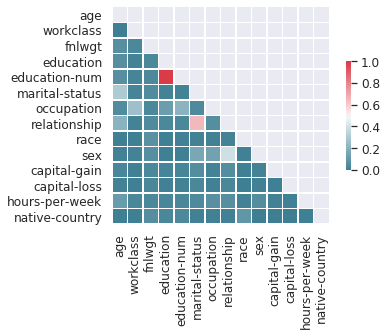

In [0]:
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(h_neg=220, h_pos=10, n=50, as_cmap=True)
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.0})
sns.heatmap(
    corrs,
    square=True,
    mask=mask,
    cmap=cmap, vmax=1.0, center=0.5,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

Most features are relatively uncorrelated, however there is one pair of variables that stands out.

In [0]:
corrs.loc['education-num', 'education']

0.9995095286140694

In [0]:
train.groupby(by='education')['education-num'].std()

education
 10th            0.0
 11th            0.0
 12th            0.0
 1st-4th         0.0
 5th-6th         0.0
 7th-8th         0.0
 9th             0.0
 Assoc-acdm      0.0
 Assoc-voc       0.0
 Bachelors       0.0
 Doctorate       0.0
 HS-grad         0.0
 Masters         0.0
 Preschool       0.0
 Prof-school     0.0
 Some-college    0.0
Name: education-num, dtype: float64

Education-num and Education are exactly the same.

The UCI description page mentions missing variables, however, we cannot see any missing values here.

In [0]:
train.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
50k               False
dtype: bool

For neural network training, for categorical variables, we have the choice of either using embeddings or feeding them as one-hot-encodings. Let us try one-hot-encodings for simplicity.

In [0]:
encoder = ce.OneHotEncoder(cols=list(X.select_dtypes(include='object').columns)[:])
encoder.fit(X, train['50k'])
X_cleaned = encoder.transform(X)

In [0]:
X_cleaned.columns

Index(['age', 'workclass_1', 'workclass_2', 'workclass_3', 'workclass_4',
       'workclass_5', 'workclass_6', 'workclass_7', 'workclass_8',
       'workclass_9',
       ...
       'native-country_33', 'native-country_34', 'native-country_35',
       'native-country_36', 'native-country_37', 'native-country_38',
       'native-country_39', 'native-country_40', 'native-country_41',
       'native-country_42'],
      dtype='object', length=108)

In [0]:
x_cleaned_cols = X_cleaned.columns

In [0]:
train['50k'].unique()

array([' <=50K', ' >50K'], dtype=object)

We are going to encode target values in two columns as 1 if present and 0 if not present. It is good to remember that the python truth values correspond to this. 

In [0]:
[int(val) for val in [True, False]]

[1, 0]

In [0]:
y = np.zeros((len(X_cleaned), 2))
y[:, 0] = train['50k'].apply(lambda x: x == ' <=50K')
y[:, 1] = train['50k'].apply(lambda x: x == ' >50K')

In [0]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

In [0]:
X_cleaned = standard_scaler.fit_transform(X_cleaned)

We are ready to start training. For good practice, we will save the dataset and our two encoders, the one-hot encoder and the standard scaler, so we can trace our changes.

In [0]:
X_cleaned.to_csv('adult_before_training.csv', index=False)

In [0]:
import joblib

In [0]:
joblib.dump([encoder, standard_scaler], 'adult_encoder.joblib')

['adult_encoder.joblib']

In [0]:
X_cleaned.shape

(32561, 108)

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(20, activation='selu', input_dim=108))
model.add(Dense(2, activation='softmax'))
model.compile(
    optimizer='rmsprop',
    loss='categorical_hinge',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                2180      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 42        
Total params: 2,222
Trainable params: 2,222
Non-trainable params: 0
_________________________________________________________________


To make this a bit more interesting, we will use a generator this time to feed in our data. We have a choice again - we can use any generator really (i.e. using a function with *yield*) and providing the *steps_per_epoch* parameter, or write a class inherits from *tensorflow.keras.utils.Sequence* that implements the following methods:
* ***len()***, for the fit_generator function to know how much more data is to come. This corresponds to *steps_per_epoch* and is $\text{len}(\text{data}) // \text{batch_size}$.
* ***__getitem__***(), for the fit_generator to ask for the next batch
*  ***on_epoch_end()***, to do some shuffling or other things at the end of an epoch - this is optional.

For simplicity, we will take the former approach. If we had not done our preprocessing already, we could put it into this function.

In [0]:
def adult_feed(X_cleaned, y, batch_size=10, shuffle=True):
  def init_batches():
    return (
        np.zeros((batch_size, X_cleaned.shape[1])),
        np.zeros((batch_size, y.shape[1]))
        )
  batch_x, batch_y = init_batches()
  batch_counter = 0
  while True:  # this is for every epoch
    indexes = np.arange(X_cleaned.shape[0])
    if shuffle == True:
      np.random.shuffle(indexes)
    for index in indexes:
      batch_x[batch_counter, :] = X_cleaned[index, :]
      batch_y[batch_counter, :] = y[index, :]
      batch_counter += 1
      if batch_counter >= batch_size:
        yield (batch_x, batch_y)
        batch_counter = 0
        batch_x, batch_y = init_batches()

history = model.fit_generator(
    adult_feed(X_cleaned, y, 10),
    steps_per_epoch=len(X_cleaned) // 10,
    epochs=50
)

Epoch 1/50
3256/3256 [==============================] - 8s 3ms/step - loss: 0.4101 - acc: 0.8008
Epoch 2/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3758 - acc: 0.8137
Epoch 3/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3737 - acc: 0.8138
Epoch 4/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3712 - acc: 0.8154
Epoch 5/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3709 - acc: 0.8156
Epoch 6/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3703 - acc: 0.8153
Epoch 7/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3680 - acc: 0.8167
Epoch 8/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3666 - acc: 0.8173
Epoch 9/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3668 - acc: 0.8167
Epoch 10/50
3256/3256 [==============================] - 7s 2ms/step - loss: 0.3658 - acc: 0.8180
Epoch 11/50
3256/3256 [======

This time we are going to plot the training progress over epochs from the history instead of using tensorboard. We did not do validation, so we are only going to plot training loss and training accuracy.

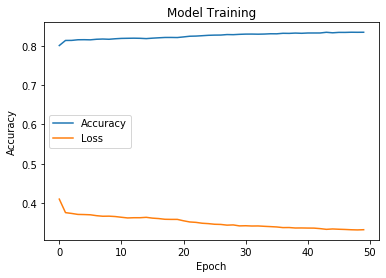

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='center left')


Now we are going to predict on test data.

In [0]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2019-12-10 22:10:44--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test’

adult.test          100%[===================>]   1.91M  2.07MB/s    in 0.9s    

2019-12-10 22:10:45 (2.07 MB/s) - ‘adult.test’ saved [2003153/2003153]



In [0]:
cols = ['age', 'workclass', 'fnlwgt',
             'education', 'education-num',
             'marital-status', 'occupation',
             'relationship', 'race', 'sex',
             'capital-gain', 'capital-loss',
             'hours-per-week', 'native-country', '50k']

test = pd.read_csv(
    'adult.test',
    names=cols
)
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50k
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [0]:
test.isnull().sum(axis=1)

0        14
1         0
2         0
3         0
4         0
         ..
16277     0
16278     0
16279     0
16280     0
16281     0
Length: 16282, dtype: int64

In [0]:
test.isnull().sum(axis=1).sum()

14

In [0]:
len(test.columns)

15

The first row has 14 nulls and 1 unusable column of 15 columns. We will discard this row. 

In [0]:
test.drop(0, axis=0, inplace=True)

In [0]:
X_test = standard_scaler.transform(encoder.transform(test[cols[:-1]]))

In [0]:
predictions = model.predict(X_test)

We will calculate the AUC score using sklearn's inbuilt functions.

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
test['50k'].unique()

array([' <=50K.', ' >50K.'], dtype=object)

Please note that the targets have slightly different names in the test set.

In [0]:
target_lookup = {' <=50K.': 0, ' >50K.': 1 }

In [0]:
y_test = test['50k'].apply(
    lambda x: target_lookup[x]
).values
roc_auc_score(y_test, predictions.argmax(axis=1))

0.754459789971816

Finally, we are going to check the feature importances of our variables. We are going to use the eli5 package for this.

In [0]:
pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


Eli5 can calculate the permutation importance, which measures the increase in the prediction error when feature values are permuted. For this to work we need a scoring function as below.

In [0]:
from eli5.permutation_importance import get_score_importances

def score(data, y=None, weight=None):
  return model.predict(data).argmax(axis=1)

base_score, score_decreases = get_score_importances(score, X_test, y_test)
feature_importances = np.mean(score_decreases, axis=0).mean(axis=1)

In [0]:
import operator


feature_importances_annotated = {col: imp for col, imp in zip(x_cleaned_cols, feature_importances)}
sorted_feature_importances_annotated = sorted(feature_importances_annotated.items(), key=operator.itemgetter(1), reverse=True)

for k, v in sorted_feature_importances_annotated:
  print('{k}: {v}'.format(k=k, v=v))

age: 0.026988514219028318
marital-status_2: 0.017492782998587312
relationship_4: 0.014286591732694552
marital-status_1: 0.011915729992015232
education_1: 0.011792887414777962
hours-per-week: 0.009471162704993551
relationship_1: 0.009274614581413917
education-num: 0.00793563048952767
occupation_5: 0.007874209200909034
relationship_2: 0.007505681469197223
sex_2: 0.006682636201707512
relationship_3: 0.006633499170812604
sex_1: 0.004729439223634912
education_4: 0.0033536023585774826
occupation_2: 0.003009643142313126
education_6: 0.0027025366992199495
marital-status_3: 0.0026411154106013145
race_1: 0.0026288311528775876
workclass_5: 0.0022848719366132305
occupation_3: 0.002198882132547141
education_9: 0.001928628462625146
occupation_1: 0.0019040599471776918
marital-status_7: 0.0018917756894539651
education_11: 0.0017566488544929672
relationship_6: 0.0017443645967692403
occupation_10: 0.001646090534979424
occupation_11: 0.001609237761808243
occupation_12: 0.001609237761808243
occupation_13:

So, yes, as expected, age is a significant factor.